In [2]:
import pandas as pd
import numpy as np
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import random
import warnings
warnings.filterwarnings('ignore')

In [3]:
RANDOM_STATE = 99

# Background

(This notebook is currently WIP) The goal of this notebook is to illustrate the dangers of Hypothesis Testing when the dataset contains __correlated observations__ violating the assumption of `Independent and Identically Distributed` observations. 

This is one of the most common errors made in hypothesis testing, as many experiments in industry will have multiple observations per user in each testing group. A quick example of what that looks like:

In [12]:
groups = ['A']*5 + ['B']*5
users = [10001, 10027, 10920, 10001, 10920, 14208, 12259, 14208, 74022, 51001]
conversion = [1, 0, 1, 1, 0, 1, 0, 1, 0, 0]
pd.DataFrame({'Observation #':range(1,11), 'Group':groups,'User':users, 'Conversion':conversion}).set_index('Observation #')

,Group,User,Conversion
Observation #,,,
1,A,10001,1
2,A,10027,0
3,A,10920,1
4,A,10001,1
5,A,10920,0
6,B,14208,1
7,B,12259,0
8,B,14208,1
9,B,74022,0


Notice how users `10001`, `10920`, and `14208` have multiple observations in the dataset. This means that
 - observations 1 and 4 are correlated
 - obervations 3 and 5 are correlated
 - observations 6 and 8 are correlated
 
To put it simply, there is __within user correlation__

The goal of this notebook will be to illustrate the potential dangers of hypothesis testing under these conditions, as well as illustrate solutions to account for correlated observations

# The Experiment

There are 2 datasets that will be used here,  `Conversions` and `Spend`, which are randomly generated datasets with correlated observations. The goal of this notebook is to demonstrate the problem with hypothesis testing when the assumptions of __iid__, __independent and identically distributed__ random variables, do not hold true

### The Issue

The dataframe, `conversions`, is going to be randomly split up (via `simple random sampling`)  into two groups, A and B. We are going to run a hypothesis test on the two randomly assigned groups with $\alpha = 0.05$. Since it is simple random sampling, there should be no significant difference between groups A and B, so we should only obtain a significant results 5% of the time (what we set $\alpha$ at).

We are going to do this repeatedly, and should expect to see only 5% of the results be significant.

In [3]:
conversions = pd.read_csv('./data/Conversions.csv')
conversions.head()

,Employee,Conversion
0,16212,1
1,42809,1
2,42809,1
3,42809,1
4,51206,1


### Splitting Employees

In [4]:
def assign_groups(employees):
    '''
    Accepts a Pandas Series type as input, and randomly assigns 
    50% of users to group A and 50% of users to group B
    '''
    
    A = pd.Series(employees.unique()).sample(frac=0.5).values
    B = employees[~employees.isin(A)].unique()
    if np.random.uniform() < 0.5:
        return A, B
    return B, A
        

In [5]:
A, B = assign_groups(conversions['Employee'])

We also need a function to get each observation for the employees from each group

In [6]:
def get_dataset(df, group):
    df = df.copy()
    return df[df.Employee.isin(group)]

And lastly, a function to get the parameters we need for our hypothesis test:
    * 1) The number of conversions
    * 2) The number of Trials

In [7]:
def get_params(df):
    N = df.shape[0]
    print
    c = df['Conversion'].sum()
    return N, c

Great, we now have a functions that randomly assigns users to a group, pull their observations from our dataset, and return their conversion rate parameters. Now we will run repeated hypothesis tests, and should expect only 5% return significant results. Since we are working with conversion rates, will will use a __Two Proportion Z-Test__ using statsmodels.

We will run 1000 repeated hypothesis tests, and should therefore expect 50 significant results

In [8]:
experiment_results = []

for _ in range(1000):
    A, B = assign_groups(conversions['Employee'])
    dfA, dfB = get_dataset(conversions, A), get_dataset(conversions, B)
    NA, cA = get_params(dfA)
    NB, cB = get_params(dfB)
    _, pval = sm.stats.proportions_ztest((cA, cB), (NA, NB))
    experiment_results.append(pval)

experiment_results = np.array(experiment_results)

In [9]:
NA, NB

(4988, 5729)

In [10]:
(experiment_results < 0.05).sum()

430

We have a lot more than 50 significant results, in fact almost half of the results are significant. So what happened? 

We violated one of the basic assumptions of this hypothesis test, __iid__ observations. Since some users have multiple observations, our observations are not __iid__, they are in fact correlated.

__So how can we correct for this?__


### Method 1: Only have 1 observation per user

If we limit our experiment to only 1 observation per user, we will satisfy the requirements for iid. Below, I will make a new `get_dataset` function that only returns 1 observation for each users

In [11]:
def get_dataset_single_record(df, group):
    df = df.copy()
    df = df[df.Employee.isin(group)]
    # selects only the first observation for each user
    df = df.groupby('Employee').first() 
    return df.reset_index()

Great, now let's repeat this experiment

In [12]:
experiment_results = []

for _ in range(1000):
    A, B = assign_groups(conversions['Employee'])
    dfA, dfB = get_dataset_single_record(conversions, A), get_dataset_single_record(conversions, B)
    NA, cA = get_params(dfA)
    NB, cB = get_params(dfB)
    _, pval = sm.stats.proportions_ztest((cA, cB), (NA, NB))
    experiment_results.append(pval)

experiment_results = np.array(experiment_results)

In [13]:
NA, NB

(498, 498)

In [14]:
(experiment_results < 0.05).sum()

64

That is much closer to what we'd expect! However, take a look at the number of observations in each group `NA` and `NB` and compare them to the number of observations in the first simulation: __we've thrown out 90% of our data in the process.__ _Surely there must be a better way_

And there is: __Generalized Linear Mixed Models (GLMMs)__!

With GLMMs, we can run hypothesis tests using all of the data we have at our disposal, without having to worry about the assumption of iid observations.

How does the model accomplish this? In this case, since there is correlation __within users__, we fit random intercepts for each user to account for it.

Let's start with a simple walkthrough of the `mixedlm` function from `statsmodels`. 

In [15]:
A, B = assign_groups(conversions['Employee'])
dfA, dfB = get_dataset(conversions, A), get_dataset(conversions, B)

def concat_groups(dfA, dfB):
    dfA, dfB = dfA.copy(), dfB.copy()
    dfA['group'] = ['A']*dfA.shape[0]
    dfB['group'] = ['B']*dfB.shape[0]
    return pd.concat((dfA,dfB))

test = concat_groups(dfA, dfB)
test.head()

,Employee,Conversion,group
0,16212,1,A
7,23178,0,A
8,23178,0,A
9,23178,0,A
11,12034,1,A


We're going to have to interface to `R` with `rpy2`. While Statsmodels supports mixed linear models, their support and documentation for mixed logit models isn't great. For a good intro to rpy2, check out this [article](https://towardsdatascience.com/guide-to-r-and-python-in-a-single-jupyter-notebook-ff12532eb3ba)

In [16]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
base = importr('base')
base.library('lme4')
# Handle warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)
from rpy2.rinterface_lib.callbacks import logger as rpy2_logger
import logging
rpy2_logger.setLevel(logging.ERROR)

R[write to console]: Loading required package: Matrix



First we'll initialize a glmer model from the lme4 package

In [17]:
glmm = robjects.r['glmer']

Next we'll initialize our formula:

$$
Conversion ~ group + (1|Employee) 
$$

where $(1|Employee)$ specifies random intercepts for Employees in the dataset

In [18]:
# Initialize formula
formula = robjects.Formula("Conversion ~ group + (1|Employee)")
formula.environment['Conversion'] = robjects.IntVector(test['Conversion'])
formula.environment['group'] = robjects.StrVector(test['group'])
formula.environment['Employee'] = robjects.IntVector(test['Employee'])

# We also need to specify the family of GLMM we will be using.
# In this case it is the binomial family (link=logit)
fam = robjects.r('binomial(link="logit")')

Lastly, we'll specify the model and checkout the output

In [19]:
res = glmm(formula=formula, family = fam)
print(base.summary(res))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: Conversion ~ group + (1 | Employee)

     AIC      BIC   logLik deviance df.resid 
 13894.1  13915.9  -6944.0  13888.1    10714 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.7564 -0.8027 -0.5456  0.8847  2.8914 

Random effects:
 Groups   Name        Variance Std.Dev.
 Employee (Intercept) 0.746    0.8637  
Number of obs: 10717, groups:  Employee, 996

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)  
(Intercept) -0.13731    0.05854  -2.346    0.019 *
groupB       0.02506    0.08175   0.307    0.759  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
       (Intr)
groupB -0.716



Looking at the summary above, a difference between groups is specified by the hypothesis test __P>|z|__ for __group[T.B]__. As expected, there is no significant difference between the groups. Now we just need an easy way to access the p-value

In [20]:
coefs = base.summary(res).rx2('coefficients')
summary = pd.DataFrame(pandas2ri.ri2py_vector(coefs), index=coefs.names[0], columns=coefs.names[1])
summary

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),-0.137312,0.05854,-2.345619,0.018996
groupB,0.025057,0.08175,0.306510,0.759216


In [21]:
pval = summary.loc['groupB','Pr(>|z|)']
pval

0.7592161614659696

Let's run our simulation again, using this hypothesis test

In [22]:
def GLMM_hypothesis_test(df):
    glmm = robjects.r['glmer']
    # Initialize formula
    formula = robjects.Formula("Conversion ~ group + (1|Employee)")
    formula.environment['Conversion'] = robjects.IntVector(df['Conversion'])
    formula.environment['group'] = robjects.StrVector(df['group'])
    formula.environment['Employee'] = robjects.IntVector(df['Employee'])
    # Initialize model family as an R onject
    fam = robjects.r('binomial(link="logit")')
    # Fit model, get p-value
    res = glmm(formula=formula, family = fam)
    coefs = base.summary(res).rx2('coefficients')
    summary = pd.DataFrame(pandas2ri.ri2py_vector(coefs), index=coefs.names[0], columns=coefs.names[1])
    pval = summary.loc['groupB','Pr(>|z|)']
    return pval


In [23]:
experiment_results = []

for _ in range(100):
    A, B = assign_groups(conversions['Employee'])
    dfA, dfB = get_dataset(conversions, A), get_dataset(conversions, B)
    testdf = concat_groups(dfA, dfB)
    pval = GLMM_hypothesis_test(testdf)
    experiment_results.append(pval)

experiment_results = np.array(experiment_results)

In [24]:
(experiment_results < 0.05).sum()

6

Great news, the Mixed Effects Hypothesis test worked! Roughly 5% of the 100 simulated tests were significant, matching the false positive rate ($\alpha = 0.05$) chosen.

# Hypothesis Test for Means

So now we're familiar with A/B testing conversion rates between two groups with correlated observations. Let's repeat the same process, but with a hypothesis test of the means

In [25]:
spend = pd.read_csv('./data/Spend.csv')
spend.head()

,Employee,Spend
0,16212,156.214205
1,42809,272.691438
2,42809,249.133289
3,42809,368.978348
4,51206,167.736721


Looking at the distributions below, it's clear we should use log(spend) for a standard hypothesis test 

Text(0.5, 1.0, 'Log Distribution of Spend')

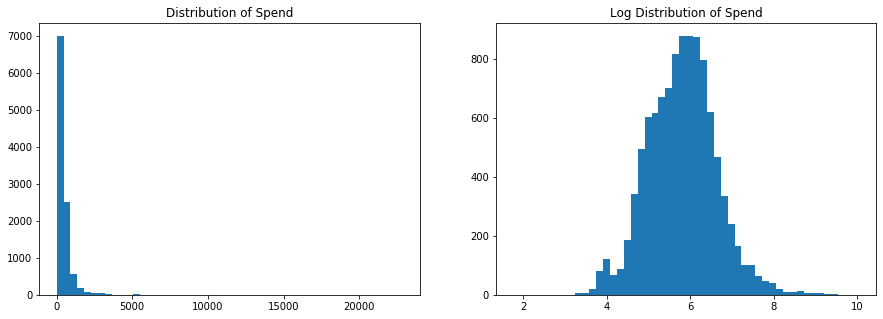

In [26]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].hist(spend['Spend'], bins=50)
ax[0].set_title('Distribution of Spend')
ax[1].hist(np.log(spend['Spend']+0.01), bins=50)
ax[1].set_title('Log Distribution of Spend')


In [27]:
def log_transform(series, invert=False):
    if invert:
        return np.exp(series) - 0.01
    return np.log(series+0.01)

In [28]:
spend['Spend'] = log_transform(spend['Spend'])

Let's simulate 1000 A/B tests again (the wrong way)

In [29]:
A, B = assign_groups(spend['Employee'])
dfA, dfB = get_dataset(spend, A), get_dataset(spend, B)


In [30]:
experiment_results = []

for _ in range(1000):
    A, B = assign_groups(spend['Employee'])
    dfA, dfB = get_dataset(spend, A), get_dataset(spend, B)
    _, pval = sm.stats.ztest(dfA['Spend'], dfB['Spend'])
    experiment_results.append(pval)

experiment_results = np.array(experiment_results)

In [31]:
(experiment_results < 0.05).sum()

470

And as expected, the correlated observations are screwing up our hypothesis tests again. We expected to see only 50 significant results, but saw closer to 500.

Let's repeat our previous process and fit a Mixed Effect Model, however this time we can do it entirely in Python since it is well support by statsmodels. A great example of this can be found [here](http://www.statsmodels.org/0.6.1/examples/notebooks/generated/mixed_lm_example.html)

In [32]:
test = concat_groups(dfA, dfB)

In [33]:
model = smf.mixedlm('Spend ~ group', test, groups = test['Employee'])
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:            MixedLM Dependent Variable: Spend      
No. Observations: 10504   Method:             REML       
No. Groups:       994     Scale:              0.5221     
Min. group size:  1       Likelihood:         -12048.6752
Max. group size:  155     Converged:          Yes        
Mean group size:  10.6                                   
---------------------------------------------------------
               Coef. Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      5.868    0.024 240.618 0.000  5.820  5.915
group[T.B]     0.038    0.034   1.102 0.270 -0.029  0.105
Group Var      0.171    0.018                            
=========================================================

"""

Next, creating a function to run the model and extract the p-value

In [34]:
def LMM_hypothesis_test(df):
    df = df.copy()
    model = smf.mixedlm('Spend ~ group', df, groups = df['Employee'])
    res = model.fit()
    return res.pvalues['group[T.B]']

Finally, we can run repeated simulations of the hypothesis test and confirm we don't get significant results more than 5% of the time (it's a slow process, so I'm only running 100 simulations)

In [35]:
experiment_results = []

for _ in range(100):
    A, B = assign_groups(spend['Employee'])
    dfA, dfB = get_dataset(spend, A), get_dataset(spend, B)
    testdf = concat_groups(dfA, dfB)
    pval = LMM_hypothesis_test(testdf)
    experiment_results.append(pval)
experiment_results = np.array(experiment_results)

In [36]:
(experiment_results < 0.05).sum()

6

Great news, this is exactly what was expected. We were able to show that correlated observations made the Z-tests effectively useless, but mixed effects models were able to correct for these correlated observations while using all of the data points available. So how can we use these Mixed Effects models for inference?

To be continued...